## Import Libraries

In [56]:
import numpy as np                                                      
import pandas as pd                                                    
import matplotlib.pyplot as plt                                        
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from nltk.corpus import stopwords
import re
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import euclidean_distances
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [57]:
df=pd.read_csv(r"C:\Users\myloe\OneDrive\Desktop\shared_articles.csv")

In [58]:
df.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


To simplify the analysis, we are only focusing on the "CONTENT SHARED" event type and making the assumption (which may not be entirely accurate) that all articles were available throughout the entire one-year period.

In [59]:
df['lang'].unique()

array(['en', 'pt', 'es', 'la', 'ja'], dtype=object)

In [60]:
# Limiting our recommendation to English Articles
df_main = df.loc[df['lang'] == 'en']

In [61]:
df_main['lang'].unique()

array(['en'], dtype=object)

Cleaning

In [62]:
def decontracted(phrase):
    """
    This function expands contracted words in a phrase.
    """
    # Dictionary of common contractions
    contractions_dict = {
        "can't": "can not",
        "won't": "will not",
        "n't": "not",
        "'ll": "will",
        "'d": "would",
        "'ve": "have",
        "'s": "is",
        "'m": "am",
        "'re": "are"
    }
    
    # Replace contractions with full words
    for contraction, full_word in contractions_dict.items():
        phrase = phrase.replace(contraction, full_word)
    
    return phrase

In [63]:
def text_preprocessing(df, feature, stemming=False, lemmatize=True):
    pattern = "[^a-zA-Z0-9]"
    english_stopwords = set(stopwords.words("english"))
    preprocessed_text = []
    for i in tqdm(range(len(df[feature]))):
        text = decontracted(df[feature].iloc[i])
        text = re.sub(pattern, ' ', text)
        text = text.lower()
        text = word_tokenize(text)
        text = [word for word in text if word not in english_stopwords and word not in string.punctuation]
        if stemming:
            porter_stemmer = PorterStemmer()
            text = [porter_stemmer.stem(word) for word in text]
        if lemmatize:
            wordnet_lemmatizer = WordNetLemmatizer()
            text = [wordnet_lemmatizer.lemmatize(word) for word in text]
        text = " ".join(text)
        preprocessed_text.append(text)
    
    return preprocessed_text

In [64]:
preprocessed_text = text_preprocessing(df_main, feature = "text")

100%|██████████| 2264/2264 [00:10<00:00, 218.94it/s]


In [65]:
preprocessed_title = text_preprocessing(df_main, feature = "title")


100%|██████████| 2264/2264 [00:00<00:00, 3870.67it/s]


Recommendation based on only the Articles

In [66]:
# All the columns are unimportant but text/ title
df_main.columns

Index(['timestamp', 'eventType', 'contentId', 'authorPersonId',
       'authorSessionId', 'authorUserAgent', 'authorRegion', 'authorCountry',
       'contentType', 'url', 'title', 'text', 'lang'],
      dtype='object')

TF-IDF is a popular technique that assigns a weight to each term in a document based on its frequency and rarity across all documents, where rarity is measured by the inverse of its document frequency.

In [67]:
vectorizer_text = TfidfVectorizer(stop_words='english')
vectorizer_title = TfidfVectorizer(stop_words='english')

In [68]:
tfidf_vectorizer_text = vectorizer_text.fit_transform(preprocessed_text)
tfidf_vectorizer_title = vectorizer_title.fit_transform(preprocessed_title)

Inertia measures the total distance of points in a cluster from its centroid, while the Dunn index additionally considers the distance between two clusters.

Clustering for text

c:\Users\myloe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 1.0, 'Clustering based on Text of the articles')

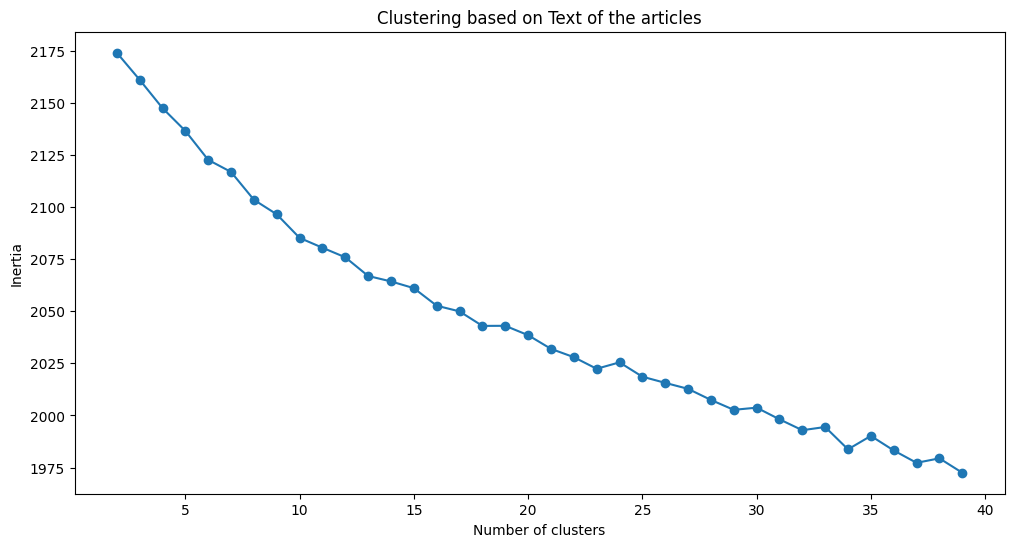

In [69]:
inertias = []
for i in range(2, 40):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100, random_state=18)
    kmeans.fit(tfidf_vectorizer_text)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(12,6))
plt.plot(range(2, 40), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Clustering based on Text of the articles')

In [70]:
# Use silhouette score to find optimal number of clusters

silhouette_scores = []
for k in range(2, 40):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, random_state=18)
    kmeans.fit(tfidf_vectorizer_text)
    silhouette_scores.append(silhouette_score(tfidf_vectorizer_text, kmeans.labels_))

optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"Optimal number of clusters: {optimal_k}")

Optimal number of clusters: 37
